In [76]:
# Dependencies
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
from config import gkey
gmaps.configure(api_key=gkey)
#api_key


# Read crime data file   

In [2]:
file='NYPD_Data.csv'
df=pd.read_csv(file)
df.head()
# convert CMPLNT_FR_DT to date format. 222398 rows records in file
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'],errors = 'coerce') 
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)"
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)"
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)"
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)"
4,145366108,25.0,MANHATTAN,2019-02-11,12:07:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,1002776.0,231994.0,40.803435,-73.933084,"(40.80343468, -73.93308448)"


In [3]:
# Filter for only "Felony" category
felonyDf = df[df["LAW_CAT_CD"] == 'FELONY'] 
felonyDf=felonyDf.reset_index(drop=True)
# Drop rows if CMPLNT_FR_DT does not have any value
felonyDf=felonyDf.dropna(subset = ['CMPLNT_FR_DT'])
# Limit our analysis to last 10 years - 2010 to 2019
felonyDf = felonyDf[(felonyDf['CMPLNT_FR_DT'] > '2010-01-01') & (felonyDf['CMPLNT_FR_DT'] <= '2019-09-06')]
# create new columns to store year and month to enable aggregration
felonyDf['CMPLNT_YR']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).year
felonyDf['CMPLNT_Month']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).month
#felonyDf.to_csv('felonyfull.csv')

felonyDf.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)",2019,3
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)",2019,1
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3


In [4]:
# Summary of felonies for the last 10 years
felonySummary=felonyDf.groupby(['CMPLNT_YR','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felonySummary=felonySummary.rename(columns={'OFNS_DESC':"Total Count"})
# Sort by total offsense count to see the top 5 categories
felonySummary=felonySummary.sort_values('Total Count',ascending=False)
felonySummary.reset_index()

,CMPLNT_YR,OFNS_DESC,Total Count
0,2019,GRAND LARCENY,18012
1,2019,FELONY ASSAULT,9680
2,2019,MISCELLANEOUS PENAL LAW,6620
3,2019,ROBBERY,5789
4,2019,CRIMINAL MISCHIEF & RELATED OF,5168
5,2019,BURGLARY,4712
6,2019,FORGERY,2594
7,2019,DANGEROUS WEAPONS,2333
8,2019,DANGEROUS DRUGS,2283
9,2019,GRAND LARCENY OF MOTOR VEHICLE,2084


In [5]:
# Limit our analysis to the top 5 offense categories , we end up with 47755 rows for our analysis
felony5 = felonyDf[(felonyDf['OFNS_DESC'] == 'GRAND LARCENY') | (felonyDf['OFNS_DESC'] == 'FELONY ASSAULT') | (felonyDf['OFNS_DESC'] == 'MISCELLANEOUS PENAL LAW') | (felonyDf['OFNS_DESC'] == 'ROBBERY') | (felonyDf['OFNS_DESC'] == 'CRIMINAL MISCHIEF & RELATED OF')]
felony5.head()
#felony5.to_csv('felony5.csv')

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3
7,816741975,18.0,MANHATTAN,2019-03-30,14:58:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3
9,530663781,44.0,BRONX,2019-03-02,7:19:00,NaN,NaN,COMPLETED,NaN,NaN,...,18-24,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3


In [6]:

# Group by CMPLNT_YR','OFNS_DESC to see aggregation for the top 5 offenses
felony5Summary=felony5.groupby(['CMPLNT_YR','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felony5Summary=felony5Summary.rename(columns={'OFNS_DESC':"Total Count"})

felony5Summary=felony5Summary.sort_values('Total Count',ascending=False)
felony5Summary=felony5Summary.reset_index()
felony5Summary.head(5)


,CMPLNT_YR,OFNS_DESC,Total Count
0,2019,GRAND LARCENY,18012
1,2019,FELONY ASSAULT,9680
2,2019,MISCELLANEOUS PENAL LAW,6620
3,2019,ROBBERY,5789
4,2019,CRIMINAL MISCHIEF & RELATED OF,5168


In [7]:
# Minor Data Munging to Re-Format the Data Frames
felony5pivot=felony5Summary.pivot(index='CMPLNT_YR',columns='OFNS_DESC', values='Total Count')
# Preview the Data Frame
felony5pivot=felony5pivot.reset_index()
felony5pivot=felony5pivot.fillna(0)
felony5pivot
#DataFrame.fillna()

OFNS_DESC,CMPLNT_YR,CRIMINAL MISCHIEF & RELATED OF,FELONY ASSAULT,GRAND LARCENY,MISCELLANEOUS PENAL LAW,ROBBERY
0,2010,0.0,2.0,3.0,0.0,0.0
1,2011,1.0,0.0,2.0,0.0,2.0
2,2012,0.0,0.0,6.0,0.0,0.0
3,2013,1.0,0.0,9.0,0.0,0.0
4,2014,1.0,1.0,9.0,1.0,0.0
5,2015,0.0,2.0,26.0,1.0,0.0
6,2016,0.0,5.0,27.0,3.0,2.0
7,2017,14.0,4.0,106.0,6.0,0.0
8,2018,328.0,106.0,1613.0,174.0,31.0
9,2019,5168.0,9680.0,18012.0,6620.0,5789.0


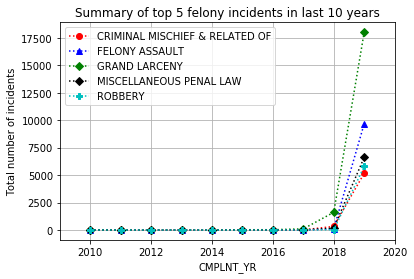

In [8]:
# Draw a line plot
ax = felony5pivot.plot( x="CMPLNT_YR",y="CRIMINAL MISCHIEF & RELATED OF", color="r", label="CRIMINAL MISCHIEF & RELATED OF",linestyle=':',marker='o')
felony5pivot.plot(x="CMPLNT_YR",y="FELONY ASSAULT", color="b", label="FELONY ASSAULT",linestyle=':',marker='^', ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="GRAND LARCENY", color="g", label="GRAND LARCENY",linestyle=':',marker='D', ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="MISCELLANEOUS PENAL LAW", color="k", label="MISCELLANEOUS PENAL LAW", linestyle=':',marker='D',ax=ax)
felony5pivot.plot(x="CMPLNT_YR",y="ROBBERY", color="c", label="ROBBERY", linestyle=':',marker='P',ax=ax)

plt.grid()
plt.xlim(2009,2020)
plt.title("Summary of top 5 felony incidents in last 10 years")
#plt.xlabel("Time (Days)")
plt.ylabel("Total number of incidents")
plt.legend()
plt.show()

In [9]:

felony5Boro=felony5.groupby(['BORO_NM','OFNS_DESC']).agg({'OFNS_DESC':'count'})
felony5Boro=felony5Boro.rename(columns={'OFNS_DESC':"Total Count"})

felony5Boro=felony5Boro.sort_values('Total Count',ascending=False)
#felony5Boro=felony5Boro.reset_index()
#felony5Boro=felony5Boro.set_index('BORO_NM')
felony5Boro=felony5Boro.sort_values('OFNS_DESC')
felony5Boro=felony5Boro.reset_index()
felony5Boro
#felony5Boro.plot()

,BORO_NM,OFNS_DESC,Total Count
0,BRONX,CRIMINAL MISCHIEF & RELATED OF,1065
1,QUEENS,CRIMINAL MISCHIEF & RELATED OF,1446
2,STATEN ISLAND,CRIMINAL MISCHIEF & RELATED OF,246
3,MANHATTAN,CRIMINAL MISCHIEF & RELATED OF,1017
4,BROOKLYN,CRIMINAL MISCHIEF & RELATED OF,1739
5,STATEN ISLAND,FELONY ASSAULT,300
6,BROOKLYN,FELONY ASSAULT,2839
7,BRONX,FELONY ASSAULT,2825
8,QUEENS,FELONY ASSAULT,1927
9,MANHATTAN,FELONY ASSAULT,1909


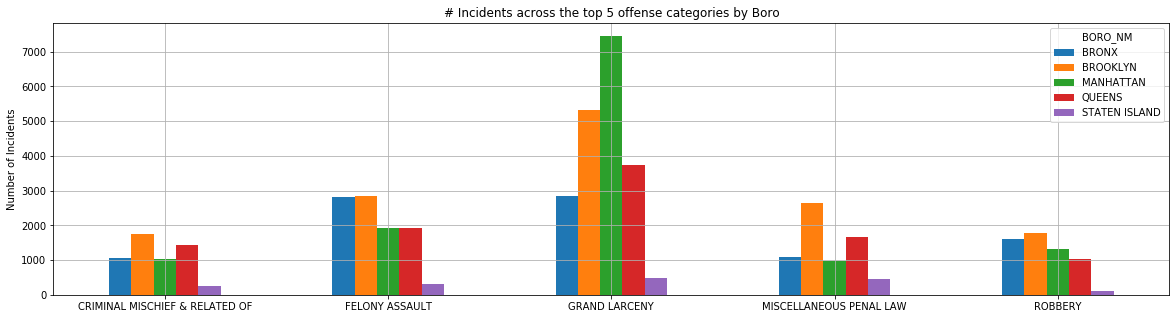

BORO_NM,OFNS_DESC,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,CRIMINAL MISCHIEF & RELATED OF,1065,1739,1017,1446,246
1,FELONY ASSAULT,2825,2839,1909,1927,300
2,GRAND LARCENY,2834,5314,7451,3738,475
3,MISCELLANEOUS PENAL LAW,1085,2646,967,1659,448
4,ROBBERY,1605,1784,1311,1027,97


<Figure size 432x288 with 0 Axes>

In [10]:
# Minor Data Munging to Re-Format the Data Frames
felony5Boropivot1=felony5Boro.pivot(index='OFNS_DESC',columns='BORO_NM', values='Total Count')
# Preview the Data Frame
felony5Boropivot1=felony5Boropivot1.reset_index()
felony5Boropivot1=felony5Boropivot1.fillna(0)
felony5Boropivot1
multi_plot = felony5Boropivot1.plot(kind="bar", figsize=(20,5))

# PandasPlot.set_xticklabels() can be used to set the tick labels as well
multi_plot.set_xticklabels(felony5Boropivot1['OFNS_DESC'], rotation=0)
plt.grid()
plt.title("# Incidents across the top 5 offense categories by Boro")
plt.ylabel("Number of Incidents")
plt.show()
plt.tight_layout()
plt.savefig("Incidents across the top 5 offense categories by Boro.png")
felony5Boropivot1
#DataFrame.fillna()

In [11]:
#Create Bins to categorzie crime times
bins=[0,4,8,12,16,20,24]
Groups=['MidNight','EarlyMor','Morning','Noon','Evening','Night']
felony5['CMPLNT_FR_TM'] = pd.to_datetime(felony5['CMPLNT_FR_TM']).dt.hour
felony5["CrimeTimes"] = pd.cut(felony5["CMPLNT_FR_TM"], bins, labels=Groups)
felony5.head()

C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda\envs\pythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month,CrimeTimes
0,857927015,10.0,MANHATTAN,2019-01-29,16,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1,Noon
2,320007604,41.0,BRONX,2019-02-06,2,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2,MidNight
4,889702556,32.0,MANHATTAN,2019-03-11,21,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3,Night
7,816741975,18.0,MANHATTAN,2019-03-30,14,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,D,991531.0,217373.0,40.763320,-73.973718,"(40.763320339, -73.973717904)",2019,3,Noon
9,530663781,44.0,BRONX,2019-03-02,7,NaN,NaN,COMPLETED,NaN,NaN,...,BLACK,M,1006999.0,245897.0,40.841585,-73.917784,"(40.841584606, -73.917783638)",2019,3,EarlyMor


In [12]:

# Group by CMPLNT_YR','MPLNT_FR_TM to see aggregation for the top 5 offenses
felony5byTime=felony5.groupby(['BORO_NM','CrimeTimes']).agg({'OFNS_DESC':'count'})
felony5byTime=felony5byTime.rename(columns={'OFNS_DESC':"Total Count"})

felony5byTime=felony5byTime.sort_values('Total Count',ascending=False)
felony5byTime=felony5byTime.sort_values('CrimeTimes')
felony5byTime=felony5byTime.reset_index()
felony5byTime




,BORO_NM,CrimeTimes,Total Count
0,STATEN ISLAND,MidNight,140
1,MANHATTAN,MidNight,1415
2,BROOKLYN,MidNight,1545
3,QUEENS,MidNight,1145
4,BRONX,MidNight,1099
5,BRONX,EarlyMor,911
6,STATEN ISLAND,EarlyMor,158
7,QUEENS,EarlyMor,927
8,MANHATTAN,EarlyMor,971
9,BROOKLYN,EarlyMor,1344


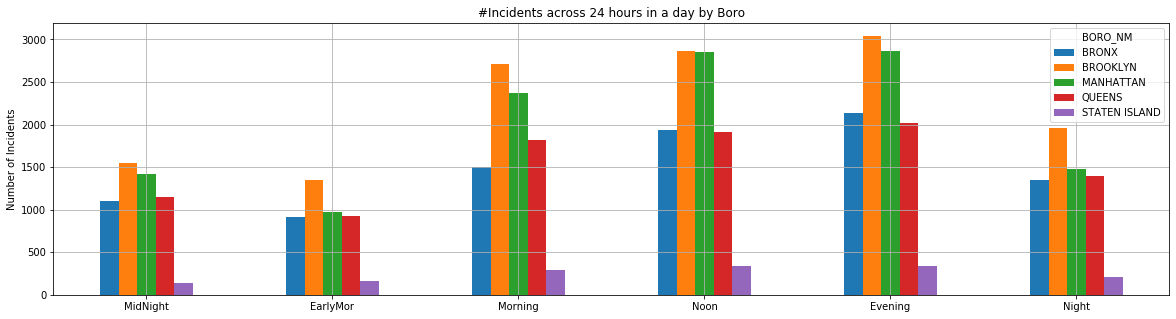

BORO_NM,CrimeTimes,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,MidNight,1099,1545,1415,1145,140
1,EarlyMor,911,1344,971,927,158
2,Morning,1502,2707,2371,1816,296
3,Noon,1936,2868,2855,1918,341
4,Evening,2130,3041,2868,2015,343
5,Night,1347,1965,1480,1399,210


<Figure size 432x288 with 0 Axes>

In [13]:
# Minor Data Munging to Re-Format the Data Frames
felony5timepivot1=felony5byTime.pivot(index='CrimeTimes',columns='BORO_NM', values='Total Count')
# Preview the Data Frame
felony5timepivot1=felony5timepivot1.reset_index()
#felony5timepivot1=felony5timepivot1.fillna(0)
felony5timepivot1
#DataFrame.fillna()
multi_plot = felony5timepivot1.plot(kind="bar", figsize=(20,5))
#multi_plot.set_xticklabels( rotation=45)
# PandasPlot.set_xticklabels() can be used to set the tick labels as well
multi_plot.set_xticklabels(felony5timepivot1["CrimeTimes"], rotation=0)
plt.title("#Incidents across 24 hours in a day by Boro")
plt.ylabel("Number of Incidents")
plt.grid()
plt.show()
plt.savefig("#Incidents across 24 hours in a day by Boro.png")
plt.tight_layout()
felony5timepivot1

## Heat Map for Crimes

In [77]:
# Store latitude and longitude in locations
locations = felony5[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
rating = felony5["CMPLNT_NUM"].astype(float)
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating)  

# Add layer
fig.add_layer(heat_layer)
#marker_locations=[(43, -72)]
#markers = gmaps.marker_layer(locations)
#fig.add_layer(markers)
#fig.add_layer(heat_layer,markers)
# Display figure
fig


Figure(layout=FigureLayout(height='420px'))